In [1]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
import keras
import imgaug.augmenters as imgaug

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
augs = [
  imgaug.Sequential([imgaug.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)})]),
  imgaug.Sequential([imgaug.Dropout(0.1)]),
  imgaug.Sequential([imgaug.GaussianBlur(sigma=(0.0, 2.0))]),
  imgaug.Sequential([imgaug.Fliplr(0.5)]),
  imgaug.Sequential([imgaug.Affine(scale=(0.5, 1.5))]),
  imgaug.Sequential([imgaug.Affine(translate_px={"x": (-20, 20), "y": (-20, 20)})]),
  imgaug.Sequential([imgaug.Rotate((-15, 15))]),
  imgaug.Sequential([imgaug.PiecewiseAffine(scale=(0.01, 0.05))]),
  imgaug.Sequential([imgaug.PerspectiveTransform(scale=(0.01, 0.15))])
]

In [3]:
TRAIN_FOLDER = './shopee-product-detection-dataset/train/train/'
VAL_FOLDER = './shopee-product-detection-dataset/train/val/'
MODEL_CHECKPOINT = './Checkpoints/inception.h5'

LOAD_WEIGHTS = False
WEIGHT_FILE = './Checkpoints/inception.h5'

In [87]:
class AugDataGenerator(keras.utils.Sequence):
  'Generates data for Keras'

  augs = [
      imgaug.Sequential([imgaug.Affine(scale={"x": (0.75, 1.0), "y": (0.75, 1.0)})]),
      imgaug.Sequential([imgaug.Dropout(0.075)]),
      imgaug.Sequential([imgaug.GaussianBlur(sigma=(0.0, 2.0))]),
      imgaug.Sequential([imgaug.Fliplr(0.5)]),
      imgaug.Sequential([imgaug.Affine(scale=(0.75, 1.0))]),
      imgaug.Sequential([imgaug.Affine(translate_px={"x": (-20, 20), "y": (-20, 20)})]),
      imgaug.Sequential([imgaug.Rotate((-15, 15))]),
      imgaug.Sequential([imgaug.PiecewiseAffine(scale=(0.01, 0.05))]),
      imgaug.Sequential([imgaug.PerspectiveTransform(scale=(0.01, 0.15))])
    ]

  def __init__(self, folder_link, batch_size=8, shuffle=False):
    self.batch_size = batch_size
    self.folder_link = folder_link
    self.shuffle = shuffle

    self.fetch_data(self.folder_link)

    self.on_epoch_end()
    
  def fetch_data(self, folder_link):
    self.X_data = []
    self.y_true = []
    
    label_counter = 0
    for class_folder in os.listdir(folder_link):
        class_folder_path = folder_link + class_folder + '/'
        for image_file in os.listdir(class_folder_path):
            if '.jpg' in image_file:
                self.X_data.append(class_folder_path + image_file)
                self.y_true.append(label_counter)
        label_counter += 1
        
    self.X_data = np.array(self.X_data)
    self.y_true = np.array(self.y_true)

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.y_true) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    #print('Index: {}'.format(index))
    # Generate indexes of the batch
    indexes = self.indexes[index*(self.batch_size//2):(index+1)*(self.batch_size//2)]
#     list_images_temp = [self.images[k] for k in indexes]

    # Generate data
    # X, y = self.__data_generation(list_images_temp)
    X, y = self.__data_generation(indexes)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.y_true))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_idxs):
    '''
    Generate data with the specified batch size
    '''
    # Initialization
    X = np.empty((self.batch_size, 224, 224, 81), dtype=np.uint8)
    y = np.empty((self.batch_size, 42), dtype=np.uint8)

    for i, idx in enumerate(list_idxs):
#       temp = np.load(self.X_data[idx])
#       X[i,] = temp['data']
      temp = cv2.imread(self.X_data[idx])
      temp = cv2.resize(temp, (224, 224))
      temp = np.concatenate([temp] * 27, -1)
        
      img_augs = [temp]
      rand_augs = np.random.choice(np.arange(len(self.augs)), 4)
      for idx in rand_augs:
        aug = self.augs[idx]
        img_augs.append(aug(image = temp))
    
      img_augs = np.array(img_augs)
      idx0, idx1 = np.random.choice(np.arange(len(img_augs)), 2)
    
      X[i * 2,] = img_augs[idx0]
      y[i * 2,] = np.zeros((42), np.uint8)
      y[i * 2,][self.y_true[idx]] = 1
        
      X[i * 2 + 1,] = img_augs[idx0]
      y[i * 2 + 1,] = np.zeros((42), np.uint8)
      y[i * 2 + 1,][self.y_true[idx]] = 1

    return X, y

In [88]:
traingen = NumpyDataGenerator(TRAIN_FOLDER, shuffle=True)

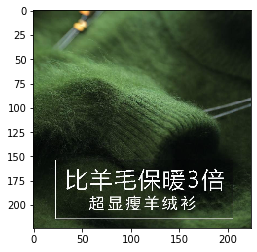

In [91]:
plt.imshow(traingen.__getitem__(2)[0][0][:, :, -3:])

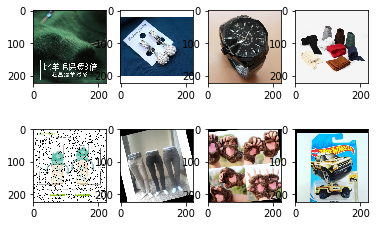

In [92]:
image_data = traingen.__getitem__(2)[0]
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(image_data[i][:, :, -3:], cv2.COLOR_RGB2BGR))